# NLP Miniproject

## Introduction

The objective of this project is to gain experience with natural language processing and how to use text data to train a machine learning model to make predictions. For the miniproject, I will be working with product review text from Amazon. The reviews are for only products in the "Electronics" category. The objective is to train a model to predict the rating, ranging from 1 to 5 stars.

## Scoring

The grader uses the [R<sup>2</sup>-score](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score) for model evaluation. 

## Downloading and loading the data

The data set is available on Amazon S3 and comes as a compressed file where each line is a JSON object. 

In [1]:
import gzip
import simplejson as json

with gzip.open("data/amazon_electronics_reviews_training.json.gz", "r") as f:                                  
    data = [json.loads(line) for line in f]

In [2]:
with gzip.open("C:/Users\DELL  LATITUDE E5480\Downloads\WQU Notebook\datacourse\machine-learning\miniprojects\data/amazon_one_and_five_star_reviews.json.gz", "r") as f:
    data1 = [json.loads(line) for line in f]

In [3]:
#Has 1000 data points
len(data)

60000

The `reviewText` key is the predictor while the `ratings` key is the target variable

In [4]:
x = [data[i]['reviewText'] for i in range(len(data))]
y = [data[i]['overall'] for i in range(len(data))]

In [5]:
#Visualizing the data points
#x[:10]
#y[:10]

In [6]:
#Splitting my data into train, test, and validation 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=0)

In [7]:
#Visualising my split dataset
print("The number of data points in train data", len(x_train))
print("The number of data points in test data", len(x_test))
print("The number of data points in validation data", len(x_val))

The number of data points in train data 38400
The number of data points in test data 12000
The number of data points in validation data 9600


**Note**, the test set used by the grader is in the same format as that of `data`, a list of dictionaries. Your trained model needs to accept data in the same format. Thus, you should use `Pipeline` when constructing your model so that all necessary transformation needed are encapsulated into a single estimator object.

## Question 1: Bag of words model

Construct a machine learning model trained on word counts using the bag of words algorithm. Remember, the bag of words is implemented with `CountVectorizer`. Some things you should consider:

* The reference solution uses a linear model and you should as well; use either `Ridge` or `SGDRegressor`.
* The text review is stored in the key `"reviewText"`. You will need to construct a custom transformer to extract out the value of this key. It will be the first step in your pipeline.
* Consider what hyperparameters you will need to tune for your model.
* Subsampling the training data will boost training times, which will be helpful when determining the best hyperparameters to use. Note, your final model will perform best if it is trained on the full data set.
* Including stop words may help with performance.

In [7]:
#Importing necessary libraries for pre-processing and feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en import STOP_WORDS
import spacy
from bs4 import BeautifulSoup
import string
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [91]:
#Performs lemmatization
nlp = spacy.load("en_core_web_sm")

# I dont think I used this block of code for anything
def lemmatizer(text):
    return [word.lemma_ for word in nlp(text)]

In [92]:
def html_parsing(corpus):
    corpus = [text.replace("\"", "") for text in corpus]
    corpus = [BeautifulSoup(text).get_text().lower().replace("\'", "") for text in corpus]
    return corpus

In [93]:
x_train = html_parsing(x_train)
x_test = html_parsing(x_test)
x_val = html_parsing(x_val)

In [94]:
import nltk

# Define a comprehensive list of negation words
negation_words = ["no", "not", "never", "none", "nobody", "nothing", "neither", "nowhere",
                  "hardly", "scarcely", "barely", "aint"]

# Define a function to handle negations
def handle_negations(corpus):
    data = []
    for text in corpus:
        # Tokenize the text
        tokens = word_tokenize(text)
        # Initialize the list of words to be used for sentiment analysis
        sentiment_words = []
        i = 0
        # Iterate through the tokens
        while i < len(tokens):
            # Check if the current token is a negation word
            if tokens[i].lower() in negation_words:
                # If it is, append "not_" to the next token
                if i+1 < len(tokens):
                    sentiment_words.append("not_"+tokens[i+1])
                    i +=1
            else:
                # If it is not, append the token to the list of sentiment words
                sentiment_words.append(tokens[i])
            i += 1
        # Join the sentiment words back into a string
        processed_text = " ".join(sentiment_words)
        data.append(processed_text)
    return data

In [95]:
x_train = handle_negations(x_train)
x_test = handle_negations(x_test)
x_val = handle_negations(x_val)

In [98]:
#Does other necessary cleaning operations
def clean(data):
    data_ = []
    #Removing all punctuation
    x = [text.translate(str.maketrans('', '', string.punctuation)) for text in data]
    #Removing all digits
    x = [text.translate(str.maketrans('', '', string.digits)) for text in x]
    #Removing stopwords and lemmatization
    for i in x:
        doc = nlp(i)
        data_.append(' '.join([text.lemma_ for text in doc if text.text not in STOP_WORDS]))
    return data_

In [99]:
#Cleaning the dataset
x_train = clean(x_train)
x_test = clean(x_test)
x_val = clean(x_val)

In [101]:
x = x_train
y = x_test
z = x_val

In [9]:
import pickle
# pickle.dump(x_train, open('x_train.pkl', 'wb'))
# pickle.dump(x_test, open('x_test.pkl', 'wb'))
# pickle.dump(x_val, open('x_val.pkl', 'wb'))

In [10]:
with open("x_train.pkl", "rb") as f:
    x_train = pickle.load(f)
with open("x_test.pkl", "rb") as f:
    x_test = pickle.load(f)

In [8]:
vect = TfidfVectorizer()

In [9]:
#fitting the countvectorizer with the training dataset
x_train_dtm = vect.fit_transform(x_train)

In [10]:
#Trasforming the test and validation dataset
x_test_dtm = vect.transform(x_test)

In [11]:
# print(x_val_dtm.shape)
# print(x_train_dtm.shape)
# print(x_test_dtm.shape)

In [12]:
print(len(y_test))

12000


In [13]:
#X.shape

In [14]:
#Trying out a model with less features
#Maybe this is not the best move. Try out with more features
vect1 = TfidfVectorizer(max_features=(x_train_dtm.shape[1])//14)
x_train_dtm1 = vect1.fit_transform(x_train)

In [15]:
x_train_dtm1.shape

(38400, 3724)

In [16]:
x_test_dtm1 = vect1.transform(x_test)
#x_val_dtm1 = vect1.fit_transform(x_val)

In [17]:
from imblearn.over_sampling import SMOTE
over = SMOTE()
X, y = over.fit_resample(x_train_dtm1, y_train)

In [18]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler()
X, y = under.fit_resample(X, y)

In [19]:
xX_test, yY_test = over.fit_resample(x_test_dtm1, y_test)
xX_test, yY_test= under.fit_resample(xX_test, yY_test)

In [20]:
x_test_dtm1.shape

(12000, 3724)

In [21]:
x_train_dtm1 = X
y_train = y

In [22]:
x_test_dtm1 = xX_test
y_test = yY_test

## Modelling/Model stacking
Models I want to stack
- NaivebayesMultinomialNB(Proability model)
- Decision Trees(tree model)
- Gradient boosting trees
- Support Vector Machines
- Neural Networks
- KNN
- Random forests
--> meta model is logistic Regression

## Decision Trees

Perform the same randomizedsearchcv on the validation dataset. prolly plot the errors and choose whats best for the train and validation set.

## DecisionTrees Train

In [25]:
def conf_mat(y, y_pred):
    conf_mat = confusion_matrix(y, y_pred, normalize="true")
    # Plot the confusion matrix
    sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis", xticklabels=set(y_train), yticklabels=set(y_train))
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    print(accuracy_score(y, y_pred))

In [27]:
#Best params is 41 and 3
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
rs_dt = RandomizedSearchCV(model,
                 {"max_depth": range(80, 100),
                 "min_samples_split": range(5, 15, 1)},
                 cv = 5,
                 n_jobs=2,
                 verbose = 1)
rs_dt.fit(x_train_dtm1, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=2,
                   param_distributions={'max_depth': range(80, 100),
                                        'min_samples_split': range(5, 15)},
                   verbose=1)

In [28]:
import pickle
# with open("dt_model.pkl", "wb") as f:
#     pickle.dump(rs_dt, f)

In [35]:
# best_alpha = rs_dt.best_params_["ccp_alpha"]
# pruned_clf = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=42)
# pruned_clf.fit(x_train_dtm1, y_train)

In [52]:
# rs_dt_train = rs_dt
max_depth = []
for i in range(len(rs_dt.cv_results_['params'])):
    max_depth.append(rs_dt.cv_results_['params'][i]["max_depth"])

In [53]:
rs_dt.cv_results_['params'][0]["max_depth"]

40

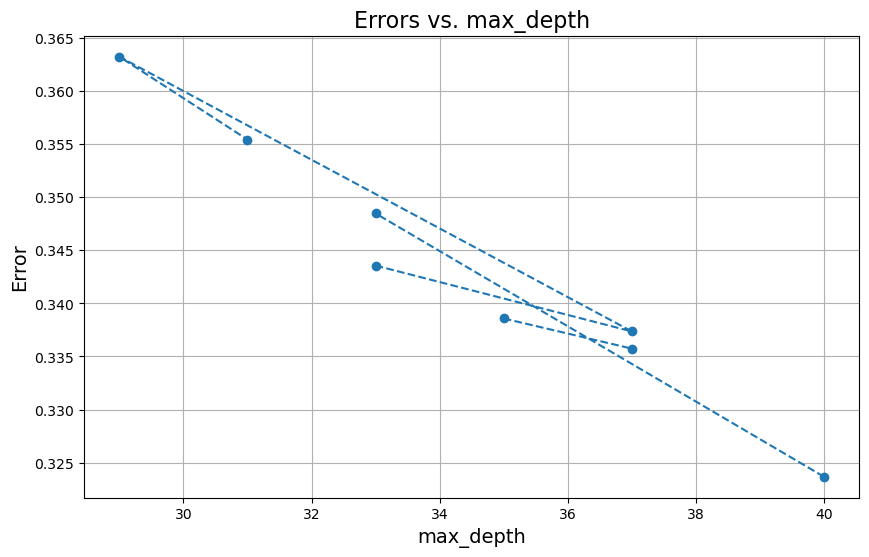

In [54]:
import matplotlib.pyplot as plt
errors = 1 - rs_dt.cv_results_['mean_test_score']

# Plot the errors with respect to the hyperparameter (max_depth in this case)
plt.figure(figsize=(10, 6))
plt.plot(max_depth, errors, "--", marker = "o")
plt.title('Errors vs. max_depth', fontsize=16)
plt.xlabel('max_depth', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.grid(True)
plt.show()


In [55]:
rs_dt_train.best_estimator_

DecisionTreeClassifier(max_depth=40, min_samples_split=5)

In [36]:
# rs_dt_test = rs_dt
#Summary and conclusion- Use max_depth of 37 and min_samples split of 6
#Creating the decision tree model try 35 as the max depth
#90 10
model_dt = rs_dt.best_estimator_
model_dt.fit(x_train_dtm1, y_train)
#43 and 9 works best for all classes

DecisionTreeClassifier(max_depth=91, min_samples_split=8)

In [41]:
path = model_dt.cost_complexity_pruning_path(x_train_dtm1, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [43]:
with open("path_pruning.pkl", "wb") as f:
    pickle.dump(path, f)

In [ ]:
#Check lenght of ccp_alphas
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, max_depth=91, min_samples_split=8, ccp_alpha=ccp_alpha)
    clf.fit(x_train_dtm1, y_train)
    clfs.append(clf)

# Evaluate the pruned decision trees
accuracies = []
for clf in clfs:
    y_pred = clf.predict(x_test_dtm1)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Find the best alpha value that gives the highest accuracy
best_alpha = ccp_alphas[accuracies.index(max(accuracies))]

# Train a decision tree with the best alpha value
pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_tree.fit(x_train_dtm1, y_train)

# Make predictions with the pruned tree
y_pred_pruned = pruned_tree.predict(x_test_dtm1)

# Calculate accuracy after pruning
accuracy_after_pruning = accuracy_score(y_test, y_pred_pruned)
print("Accuracy after pruning:", accuracy_after_pruning)

In [1]:
# #Summary and conclusion- Use max_depth of 37 and min_samples split of 6
# #Creating the decision tree model try 35 as the max depth
# #90 10
# model_dt = DecisionTreeClassifier(max_depth = 100, min_samples_split = 10)
# model_dt.fit(train_val_data, train_val_y)
# #43 and 9 works best for all classes

In [37]:
y_pred_train = model_dt.predict(x_train_dtm1)
y_pred_test = model_dt.predict(x_test_dtm1)

0.9421182586094867


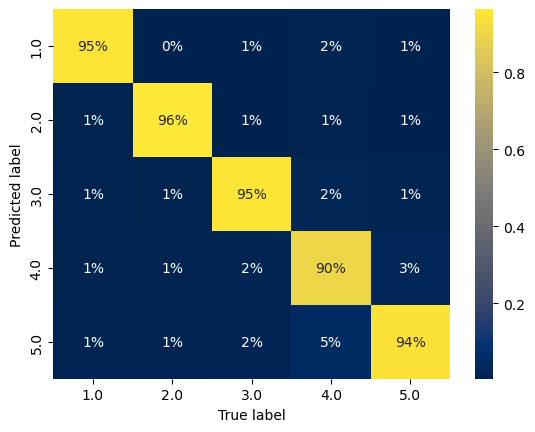

In [38]:
conf_mat(y_pred_train, y_train)

0.35259156876295783


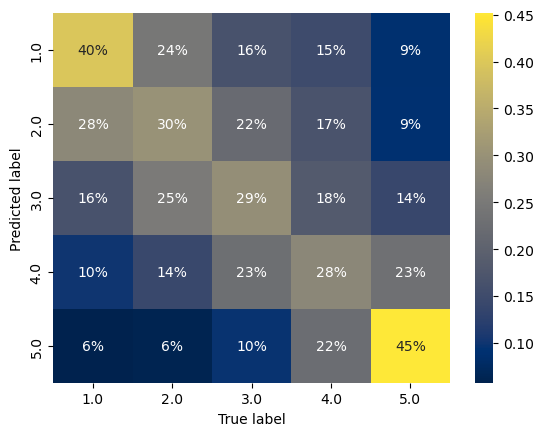

In [39]:
conf_mat(y_pred_test, y_test)

In [107]:
from scipy.sparse import vstack

train_val_data = vstack((x_train_dtm1, x_test_dtm1))
train_val_data.shape
# a = np.array([1,2,3])
# b = np.array([4,5,6])
# np.hstack((a,b))
# type(x_train_dtm1)

(74575, 5349)

In [126]:
train_val_y = y_train + y_test

In [125]:
len(y_test)

36175

In [46]:
# with open("rs_models", "wb") as f:
#     pickle.dump(rs, f)

In [47]:
# with open("rs_models_test", "wb") as f:
#     pickle.dump(rs_test, f)

In [40]:
model_dt_test = rs_test.best_estimator_
model_dt_test.fit(x_test_dtm1, y_test)

DecisionTreeClassifier(max_depth=32)

In [24]:
# with open("model_dt", "wb") as f:
#     pickle.dump(model_dt, f)

In [35]:
y_pred_train = model_dt.predict(x_train_dtm1)
y_pred_test = model_dt.predict(x_test_dtm1)

In [41]:
y_pred_train = model_dt_test.predict(x_train_dtm1)
y_pred_test = model_dt_test.predict(x_test_dtm1)

In [23]:
#This is overfitting
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
#Create the confusion matrix
#The best decision trees can do. Although you can try increasing max_depth
conf_mat = confusion_matrix(y_test, y_pred_test, normalize="true")
# Plot the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis", xticklabels=set(y_train), yticklabels=set(y_train))
plt.xlabel("True label")
plt.ylabel("Predicted label")
accuracy_score(y_train, y_pred_train)

## Naive bayes multinomial nb

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PowerTransformer
params_NB = {'var_smoothing': np.<a onclick="parent.postMessage({'referent':'.numpy.logspace'}, '*')">logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=model, param_grid=params_NB, cv=cv_method,verbose=1,scoring='accuracy')
Data_transformed = PowerTransformer().fit_transform(X_test)
gs_NB.fit(Data_transformed, y_test)

SyntaxError: invalid syntax (3706014517.py, line 3)

0.44740843123704216


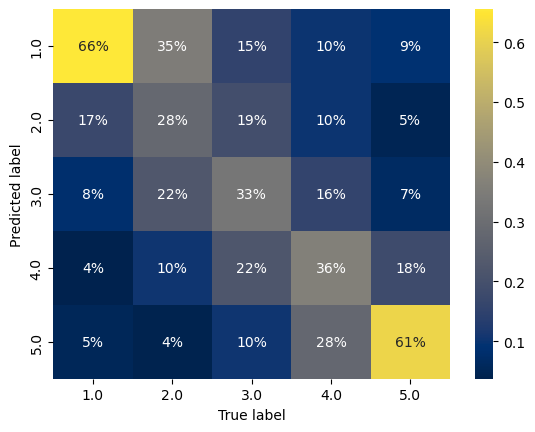

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB() #instantiate a Multinomial Naive Bayes classifier
nb.fit(x_train_dtm1, y_train)#train the mode 
y_pred_class = nb.predict(x_test_dtm1)#make class predictions for test
# Create the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_class, normalize="true")
# Plot the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis", xticklabels=set(y_train), yticklabels=set(y_train))
plt.xlabel("True label")
plt.ylabel("Predicted label")
print(accuracy_score(y_test, y_pred_class))

0.5840762399826728


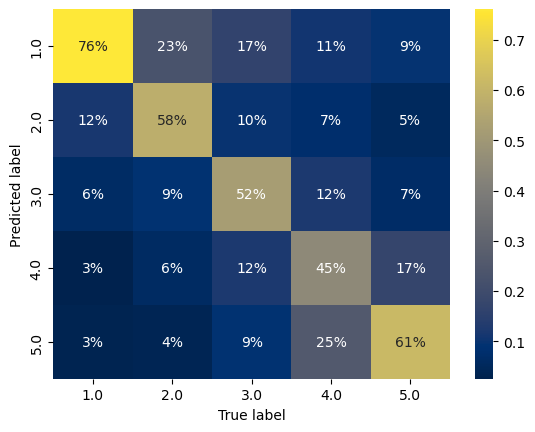

In [26]:
y_pred_train = nb.predict(x_train_dtm1)
conf_mat(y_train, y_pred_train)

In [177]:
y_pred_Train = nb.predict(x_train_dtm1)

In [179]:
accuracy_score(y_train, y_pred_Train)

0.5786197916666667

In [49]:
X.shape, type(y)

((115425, 5000), list)

## Logistic Regeression

In [172]:
#This is performing a little bit better
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight="balanced")
logreg.fit(X, y)
y_pred_class = logreg.predict(x_test_dtm1)
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

Accuracy:  0.5658333333333333


C:\Users\DELL  LATITUDE E5480\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5658333333333333


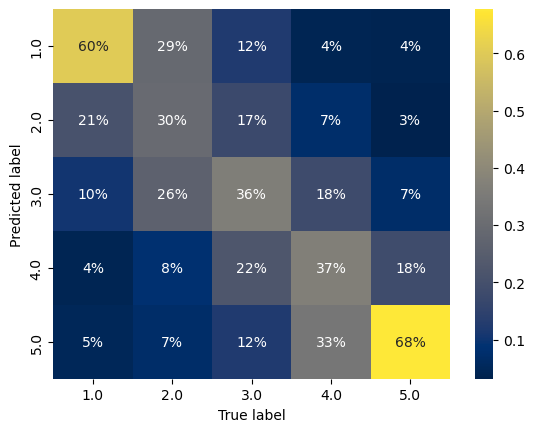

In [173]:
from sklearn.metrics import accuracy_score
# Create the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_class, normalize="true")
# Plot the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis", xticklabels=set(y_train), yticklabels=set(y_train))
plt.xlabel("True label")
plt.ylabel("Predicted label")
print(accuracy_score(y_test, y_pred_class))

## Support Vector Machines

In [33]:
from sklearn.svm import LinearSVC
#What about trying a nonlinear kernel
# classifier = LinearSVC(class_weight='balanced') 
# classifier.fit(x_train_dtm1, y_train) #fit the model with training data
# y_pred_test = classifier.predict(x_test_dtm1)

In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
model_svc = LinearSVC(class_weight='balanced') 
gs_svc = RandomizedSearchCV(model_svc,
                 {"C": np.logspace(-3,3, 20)},
                 cv = 5,
                 n_jobs=2,
                 verbose = 1)
gs_svc.fit(x_train_dtm1, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


0.6693229166666667

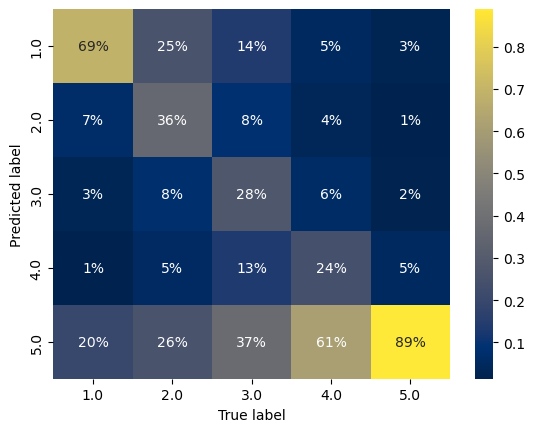

In [194]:
model_svc = gs_svc.best_estimator_
model_svc.fit(x_train_dtm1, y_train)
y_pred_train = model_svc.predict(x_train_dtm1)
# Create the confusion matrix
conf_mat = confusion_matrix(y_train, y_pred_train, normalize="true")
# Plot the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis", xticklabels=set(y_train), yticklabels=set(y_train))
plt.xlabel("True label")
plt.ylabel("Predicted label")
#y_pred_train = model.predict(x_train_dtm1)
accuracy_score(y_train, y_pred_train)

0.6409166666666667

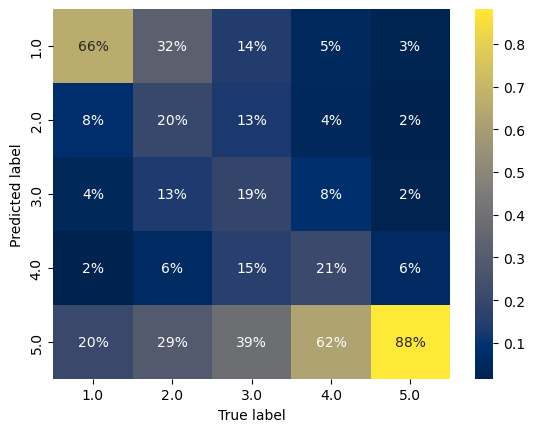

In [195]:
y_pred_test = model_svc.predict(x_test_dtm1)
# Create the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_test, normalize="true")
# Plot the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis", xticklabels=set(y_train), yticklabels=set(y_train))
plt.xlabel("True label")
plt.ylabel("Predicted label")
#y_pred_train = model.predict(x_train_dtm1)
accuracy_score(y_test, y_pred_test)

Accuracy:  0.5490833333333334
0.5490833333333334


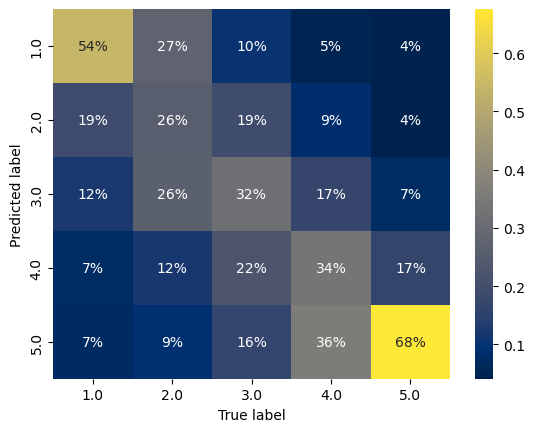

In [175]:
#Svms perform much better
#You can try this with much less features (100..prolly use pca to choose your 1000 features)
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
# Create the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_class, normalize="true")
# Plot the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis", xticklabels=set(y_train), yticklabels=set(y_train))
plt.xlabel("True label")
plt.ylabel("Predicted label")
print(accuracy_score(y_test, y_pred_class))

## KNN'S (should I still use this given its prediction time)

In [1]:
from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier()
# knn.fit(x_train_dtm1, y_train)

In [2]:
#change the distance metric to cosine similarity
from sklearn.model_selection import GridSearchCV
model_knn = KNeighborsClassifier()
gs_knn = GridSearchCV(model_knn,
                 {"n_neighbors": range(1,36,1)},
                 cv = 5,
                 n_jobs=2,
                 verbose = 1)
gs_knn.fit(x_train_dtm1, y_train)

In [ ]:
model_dt = gs.best_estimator_
model_dt.fit(x_train_dtm1, y_train)

C:\Users\DELL  LATITUDE E5480\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.7801169590643274

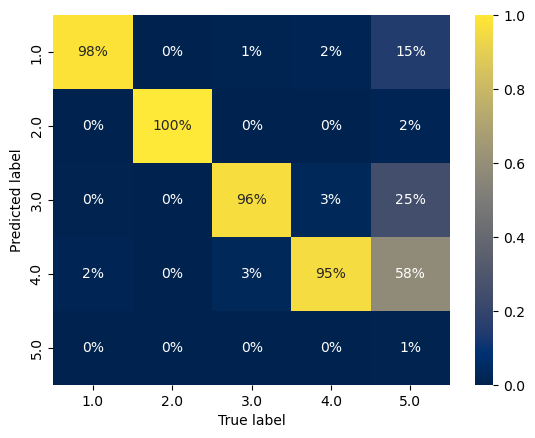

In [201]:
y_pred_train = knn.predict(x_train_dtm1)
# Create the confusion matrix
conf_mat = confusion_matrix(y_train, y_pred_train, normalize="true")
# Plot the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis", xticklabels=set(y_train), yticklabels=set(y_train))
plt.xlabel("True label")
plt.ylabel("Predicted label")
accuracy_score(y_train, y_pred_train)

In [ ]:
with open("knn_model.pkl", "wb") as f:
    pickle.dump(knn,f)

## Gradient boosting trees

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
model = GradientBoostingClassifier()
rs = RandomizedSearchCV(model,
                 {"learning_rate": [0.9,1.0]},
                 cv = 5,
                 n_jobs=2,
                 verbose = 1)
rs.fit(x_train_dtm1, y_train)
#GradientBoostingClassifier?

0.562


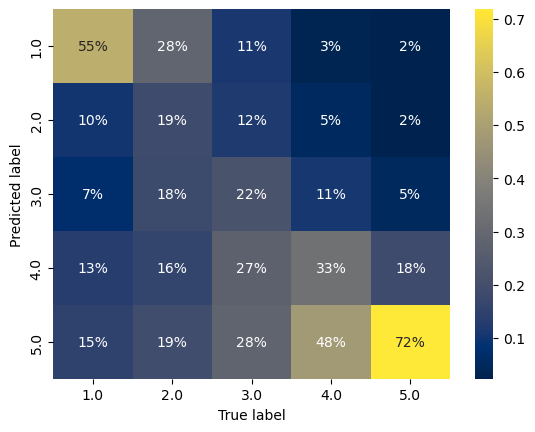

In [38]:
m_gboost = rs.best_estimator_
m_gboost.fit(x_train_dtm1, y_train)
y_pred_train = m_gboost.predict(x_test_dtm1)
conf_mat(y_test, y_pred_train)

0.7166038553173056


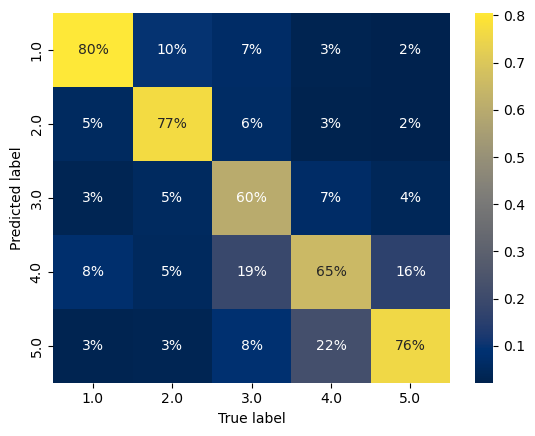

In [40]:
y_pred_train = m_gboost.predict(x_train_dtm1)
conf_mat(y_train, y_pred_train)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#Best params is 41 and 3
model = RandomForestClassifier()
rs_forest = RandomizedSearchCV(model,
                 {"n_estimators": range(50, 100, 10),
                  "max_depth": range(29, 45),
                 "min_samples_split": range(1, 10, 1)},
                 cv = 5,
                 n_jobs=2,
                 verbose = 1)
rs_test.fit(x_test_dtm1, y_test)